## Solutions for ROS Perception Project

<img src="../img/robotignite_logo_text.png"/>

## Index: 

* <a href="#SolutionStep2">Solution Task 1</a>
* <a href="#SolutionStep3">Solution Task 2</a>
* <a href="#SolutionStep4">Solution Task 3</a>

Before starting with the current tasks, we're going to create a package where we'll place all the solutions for this projects. We can call it **aibo_project_solutions**.

<table style="float:left;background: #407EAF">
<tr>
<th>
<p class="transparent">Execute in WebShell #1</p>
</th>
</tr>
</table>

In [ ]:
cd ~/catkin_ws/src;

In [ ]:
catkin_create_pkg project_control

Inside this package, create 2 new folder: **launch** and **scripts**.

## Solution Task 1: People perception exercise <p id="SolutionStep2"></p>

Next, you will create 2 new folders inside your package: **config** and **launch**. Inside these folders, you will place the following files. Inside the **config** folder, you will place the **project_control.yaml** file, and inside the **launch** folder you will place the **project_control.launch** file.

<p style="background:#3B8F10;color:white;" id="prg-2-1">**Launch File: face_detection_tc.launch** </p>

In [ ]:
<?xml version="1.0" encoding="UTF-8"?>

<launch>

    <arg name="camera" default="head_camera" />
    <arg name="depth_ns" default="depth_registered" />
    <arg name="image_topic" default="image_raw" />
    <arg name="depth_topic" default="image_raw" />
    <arg name="fixed_frame" default="optical_frame" />
    <arg name="rgb_ns" default="rgb" />
    
    <!--
    DEAPTH ==> /head_camera/depth_registered/points or /head_camera/depth_registered/image_raw
    RGB ==> /head_camera/rgb/image_raw
    rostopic echo /face_detector/people_tracker_measurements_array
    rosnode info /face_detector
    -->
    
    <node pkg="face_detector" type="face_detector" name="face_detector" output="screen">
        <remap from="camera" to="$(arg camera)" />
        <remap from="image_topic" to="$(arg image_topic)" />
        <remap from="depth_topic" to="$(arg depth_topic)" />
        <remap from="depth_ns" to="$(arg depth_ns)" />
        <remap from="rgb_ns" to="$(arg rgb_ns)" />
        <param name="fixed_frame" type="string" value="$(arg fixed_frame)" />
        
        <param name="classifier_name" type="string" value="frontalface" />
        <rosparam command="load" file="$(find face_detector)/param/classifier.yaml"/>
        <param name="classifier_reliability" type="double" value="0.6"/>
        <param name="do_continuous" type="bool" value="true" />
        <param name="do_publish_faces_of_unknown_size" type="bool" value="false" /> 
        <param name="do_display" type="bool" value="false" />
        <param name="use_rgbd" type="bool" value="true" />
        <param name="approximate_sync" type="bool" value="true" />
    </node>
    
    <!-- The  face_detector needs for someone to subscribe to publish data and detect people's faces -->

    <node   pkg="aibo_project_solutions"
            type="face_detector_client.py"
            name="face_detection_client_start_node"
            output="screen">
    </node>
    
</launch>

<p style="background:#3B8F10;color:white;" id="prg-2-1">**END Launch File: face_detection_tc.launch** </p>

<p style="background:#3B8F10;color:white;" id="prg-2-1">**Python File: face_detector_client.py** </p>

In [ ]:
#!/usr/bin/env python

import rospy
from people_msgs.msg import PositionMeasurementArray
import numpy
from move_aibo import AiboJointMover
import time
# Move base using navigation stack

"""
# PositionMeasurementArray
std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
people_msgs/PositionMeasurement[] people
  std_msgs/Header header
    uint32 seq
    time stamp
    string frame_id
  string name
  string object_id
  geometry_msgs/Point pos
    float64 x
    float64 y
    float64 z
  float64 reliability
  float64[9] covariance
  byte initialization
float32[] cooccurrence
"""

class FaceDetectClient(object):

    def __init__(self):
        self.face_detect_subs = rospy.Subscriber(   "/face_detector/people_tracker_measurements_array",
                                                    PositionMeasurementArray,
                                                    self.face_detect_subs_callback)
                                                    
        self.min_wigle_tail_distance = 1.0

    
        self.pos_mesurement_array = PositionMeasurementArray()
        
        self.aibo_mover = AiboJointMover()
        
        # We set the head to a serahc faces tilt
        self.aibo_mover.pub_headTilt_position.publish(-0.3)
    
    def face_detect_subs_callback(self,msg):
        
        pos_mesurement_array = msg
        for people_data in pos_mesurement_array.people:
            person_name = people_data.name
            person_id = people_data.object_id
            distance = self.get_vector_magnitude(people_data.pos)
            
            rospy.loginfo("#################")
            rospy.loginfo("Name="+str(person_name))
            rospy.loginfo("person_id="+str(person_id))
            rospy.loginfo("distance="+str(distance))
            rospy.loginfo("####### END #######")
            
            if distance < self.min_wigle_tail_distance:
                self.wiggle_tail()
                
                
    def wiggle_tail(self):
        """
        Move the Tail for a Second
        """
        rospy.loginfo("Wiggle Tail!")
        
        tailPan_min = -0.7
        tailPan_max = 0.7
        sleep_time = 0.2
        
        for i in range(3):
            self.aibo_mover.pub_tailPan_position.publish(tailPan_min)
            time.sleep(sleep_time)
            self.aibo_mover.pub_tailPan_position.publish(tailPan_max)
            time.sleep(sleep_time)
            
    
    def get_vector_magnitude(self, point_object):
        """
        Returns the magnitude of the point vector
        """
        numpy_array_vector = numpy.array((point_object.x, point_object.y, point_object.z))
    
        magnitude = numpy.linalg.norm(numpy_array_vector)
    
        return magnitude

    
def Face_DetectionClient_Start():
    # Create a node
    rospy.init_node("face_detection_client_start_node", log_level=rospy.INFO)

    # Make sure sim time is working
    while not rospy.Time.now():
        pass

    face_detector_client = FaceDetectClient()

    rospy.spin()

if __name__ == "__main__":
    Face_DetectionClient_Start()

<p style="background:#3B8F10;color:white;" id="prg-2-1">**END Python File: face_detector_client.py** </p>

<p style="background:#3B8F10;color:white;" id="prg-2-1">**Python File: move_aibo.py** </p>

In [ ]:
#!/usr/bin/env python
import rospy
import time
from math import pi, sin, cos, acos
import random
from std_msgs.msg import Float64
from sensor_msgs.msg import JointState
"""
Topics To Write on:
type: std_msgs/Float64
/aibo_tc/L_ear_joint_position_controller/command
/aibo_tc/L_ear_tilt_position_controller/command
/aibo_tc/R_ear_joint_position_controller/command
/aibo_tc/R_ear_tilt_position_controller/command
/aibo_tc/mouth_joint_position_controller/command
/aibo_tc/tailPan_position_controller/command
/aibo_tc/tailTilt_position_controller/command


/aibo_tc/legLB1_position_controller/command
/aibo_tc/legLB2_position_controller/command
/aibo_tc/legLB3_position_controller/command
/aibo_tc/legLF1_position_controller/command
/aibo_tc/legLF2_position_controller/command
/aibo_tc/legLF3_position_controller/command

/aibo_tc/legRB1_position_controller/command
/aibo_tc/legRB2_position_controller/command
/aibo_tc/legRB3_position_controller/command
/aibo_tc/legRF1_position_controller/command
/aibo_tc/legRF2_position_controller/command
/aibo_tc/legRF3_position_controller/command

/aibo_tc/headPan_position_controller/command
/aibo_tc/headTilt_position_controller/command
/aibo_tc/neck_joint_position_controller/command


"""

class AiboJointMover(object):

    def __init__(self):
        
        rospy.loginfo("aibo JointMover Initialising...")

        # LEFT SIDE
        self.pub_legLB1_position = rospy.Publisher(
            '/aibo_tc/legLB1_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legLB2_position = rospy.Publisher(
            '/aibo_tc/legLB2_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legLB3_position = rospy.Publisher(
            '/aibo_tc/legLB3_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legLF1_position = rospy.Publisher(
            '/aibo_tc/legLF1_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legLF2_position = rospy.Publisher(
            '/aibo_tc/legLF2_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legLF3_position = rospy.Publisher(
            '/aibo_tc/legLF3_position_controller/command',
            Float64,
            queue_size=1)

        # RIGHT SIDE
        self.pub_legRB1_position = rospy.Publisher(
            '/aibo_tc/legRB1_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legRB2_position = rospy.Publisher(
            '/aibo_tc/legRB2_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legRB3_position = rospy.Publisher(
            '/aibo_tc/legRB3_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legRF1_position = rospy.Publisher(
            '/aibo_tc/legRF1_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legRF2_position = rospy.Publisher(
            '/aibo_tc/legRF2_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_legRF3_position = rospy.Publisher(
            '/aibo_tc/legRF3_position_controller/command',
            Float64,
            queue_size=1)

        # Head
        self.pub_headPan_position = rospy.Publisher(
            '/aibo_tc/headPan_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_headTilt_position = rospy.Publisher(
            '/aibo_tc/headTilt_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_neck_joint_position = rospy.Publisher(
            '/aibo_tc/neck_joint_position_controller/command',
            Float64,
            queue_size=1)
            
        # Tail
        self.pub_tailPan_position = rospy.Publisher(
            '/aibo_tc/tailPan_position_controller/command',
            Float64,
            queue_size=1)
        self.pub_tailTilt_position = rospy.Publisher(
            '/aibo_tc/tailTilt_position_controller/command',
            Float64,
            queue_size=1)
            
            
            

        


        joint_states_topic_name = "/aibo_tc/joint_states"
        rospy.Subscriber(joint_states_topic_name, JointState, self.aibo_joints_callback)
        aibo_joints_data = None
        rate_try = rospy.Rate(1)
        while aibo_joints_data is None and not rospy.is_shutdown():
            try:
                aibo_joints_data = rospy.wait_for_message(joint_states_topic_name, JointState, timeout=1)
            except:
                rospy.logwarn("Time out " + str(joint_states_topic_name))
                rate_try.sleep()



        self.aibo_joint_dictionary = dict(zip(aibo_joints_data.name, aibo_joints_data.position))
        self.aibo_desired_joint_dictionary = dict(zip(aibo_joints_data.name, len(aibo_joints_data.name)*[0]))

        self.max_1 = 2.0
        self.middle_1 = 1.5
        self.small_1 = 0.7
        self.smallb_1 = 0.4
        self.smallc_1 = 0.3
        self.max_2 = 1.5
        self.middle_2 = 0.8
        self.smallb_2 = 0.3
        self.max_3 = 1.9
        self.middle_3 = 1.5
        self.small_3 = 0.7
        self.smallb_3 = 0.1

        self.fill_in_initpos1(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos2(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos3(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos4(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos5(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos6(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos7(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_initpos8(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_centerpos(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_walkinit_pos(joint_name_list=aibo_joints_data.name,
                              positions_list=aibo_joints_data.position)
        self.fill_in_walk_pos1(joint_name_list=aibo_joints_data.name,
                                  positions_list=aibo_joints_data.position)
        self.fill_in_walk_pos2(joint_name_list=aibo_joints_data.name,
                                  positions_list=aibo_joints_data.position)
        self.fill_in_walk_pos3(joint_name_list=aibo_joints_data.name,
                               positions_list=aibo_joints_data.position)
        self.fill_in_walk_pos4(joint_name_list=aibo_joints_data.name,
                               positions_list=aibo_joints_data.position)

    def fill_in_initpos1(self, joint_name_list, positions_list):
        """
        {'mouth_joint': 0,
        'tailPan': 0,
        'L_ear_joint': 0,
        'R_ear_tilt': 0,
        'tailTilt': 0,
        'headPan': 0,
        'headTilt': 0,
        'R_ear_joint': 0,
        L_ear_tilt': 0,
        'neck_joint': 0,
        'legRF2': 0,
        'legRF3': 0,
        'legRF1': 0,
        'legLF1': 0,
        'legLF2': 0,
        'legLF3': 0,
        'legLB1': 0,
        'legLB2': 0,
        'legLB3': 0,
        'legRB2': 0,
        'legRB3': 0,
        'legRB1': 0}
        :param joint_name_list:
        :param positions_list:
        :return:
        """
        self.INIT_POS_1 = dict(zip(joint_name_list, positions_list))


        init1_dict = {"legRF1": -self.max_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": -self.max_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": self.max_1, "legRB2": 0, "legRB3": 0,
                      "legLB1": self.max_1, "legLB2": 0, "legLB3": 0,
                      "headPan": -1.62, "headTilt": -0.87, "neck_joint": 0,
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_1[key] = value

    def fill_in_initpos2(self, joint_name_list, positions_list):

        self.INIT_POS_2 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.max_1, "legRF2": self.middle_2, "legRF3": 0,
                      "legLF1": -self.max_1, "legLF2": self.middle_2, "legLF3": 0,
                      "legRB1": self.max_1, "legRB2": self.middle_2, "legRB3": 0,
                      "legLB1": self.max_1, "legLB2": self.middle_2, "legLB3": 0,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_2[key] = value

    def fill_in_initpos3(self, joint_name_list, positions_list):

        self.INIT_POS_3 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.max_1, "legRF2": self.max_2, "legRF3": 0,
                      "legLF1": -self.max_1, "legLF2": self.max_2, "legLF3": 0,
                      "legRB1": self.max_1, "legRB2": self.max_2, "legRB3": 0,
                      "legLB1": self.max_1, "legLB2": self.max_2, "legLB3": 0,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_3[key] = value

    def fill_in_initpos4(self, joint_name_list, positions_list):

        self.INIT_POS_4 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": 0, "legRF2": self.max_2, "legRF3": 0,
                      "legLF1": 0, "legLF2": self.max_2, "legLF3": 0,
                      "legRB1": 0, "legRB2": self.max_2, "legRB3": 0,
                      "legLB1": 0, "legLB2": self.max_2, "legLB3": 0,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_4[key] = value

    def fill_in_initpos5(self, joint_name_list, positions_list):

        self.INIT_POS_5 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.middle_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": -self.middle_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": -self.max_1, "legRB2": 0, "legRB3": self.max_3,
                      "legLB1": -self.max_1, "legLB2": 0, "legLB3": self.max_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_5[key] = value

    def fill_in_initpos6(self, joint_name_list, positions_list):

        self.INIT_POS_6 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.middle_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": -self.middle_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": -self.middle_1, "legRB2": 0, "legRB3": self.middle_3,
                      "legLB1": -self.middle_1, "legLB2": 0, "legLB3": self.middle_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_6[key] = value

    def fill_in_initpos7(self, joint_name_list, positions_list):

        self.INIT_POS_7 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.smallb_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": -self.smallb_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": -self.small_1, "legRB2": 0, "legRB3": self.middle_3,
                      "legLB1": -self.small_1, "legLB2": 0, "legLB3": self.middle_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_7[key] = value


    def fill_in_initpos8(self, joint_name_list, positions_list):

        self.INIT_POS_8 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.smallb_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": -self.smallb_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": -self.smallb_1, "legRB2": 0, "legRB3": self.small_3,
                      "legLB1": -self.smallb_1, "legLB2": 0, "legLB3": self.small_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.INIT_POS_8[key] = value

    def fill_in_centerpos(self, joint_name_list, positions_list):

        self.CENTER_POS = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": 0, "legRF2": 0, "legRF3": 0,
                      "legLF1": 0, "legLF2": 0, "legLF3": 0,
                      "legRB1": 0, "legRB2": 0, "legRB3": 0,
                      "legLB1": 0, "legLB2": 0, "legLB3": 0,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.CENTER_POS[key] = value

    def fill_in_walkinit_pos(self, joint_name_list, positions_list):

        self.WALK_INIT_POS_1 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.smallc_1, "legRF2": 0, "legRF3": self.small_3,
                      "legLF1": -self.smallc_1, "legLF2": 0, "legLF3": self.small_3,
                      "legRB1": -self.smallc_1, "legRB2": 0, "legRB3": self.smallb_3,
                      "legLB1": -self.smallc_1, "legLB2": 0, "legLB3": self.smallb_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_INIT_POS_1[key] = value

    def fill_in_walk_pos1(self, joint_name_list, positions_list):

        self.WALK_POS_1 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.smallc_1, "legRF2": 0, "legRF3": -self.smallb_3,
                      "legLF1": -self.smallb_1, "legLF2": -self.smallb_2, "legLF3": -self.small_3,
                      "legRB1": -self.smallc_1, "legRB2": 0, "legRB3": self.smallb_3,
                      "legLB1": -self.smallc_1, "legLB2": 0, "legLB3": self.smallb_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_POS_1[key] = value

    def fill_in_walk_pos2(self, joint_name_list, positions_list):

        self.WALK_POS_2 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": self.smallc_1, "legRF2": 0, "legRF3": -self.smallb_3,
                      "legLF1": -self.smallb_1, "legLF2": 0, "legLF3": self.smallb_3,
                      "legRB1": self.smallc_1, "legRB2": 0, "legRB3": self.smallb_3,
                      "legLB1": self.smallc_1, "legLB2": 0, "legLB3": self.smallb_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_POS_2[key] = value

    def fill_in_walk_pos3(self, joint_name_list, positions_list):

        self.WALK_POS_3 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": self.smallb_1, "legRF2": 0, "legRF3": -self.smallb_3,
                      "legLF1": self.smallb_1, "legLF2": 0, "legLF3": self.smallb_3,
                      "legRB1": -self.small_1, "legRB2": 0, "legRB3": self.max_3,
                      "legLB1": self.smallb_1, "legLB2": 0, "legLB3": self.smallb_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_POS_3[key] = value

    def fill_in_walk_pos4(self, joint_name_list, positions_list):

            self.WALK_POS_4 = dict(zip(joint_name_list, positions_list))

            init1_dict = {"legRF1": self.small_1, "legRF2": 0, "legRF3": -self.smallb_3,
                          "legLF1": self.small_1, "legLF2": 0, "legLF3": self.smallb_3,
                          "legRB1": -self.smallc_1, "legRB2": 0, "legRB3": self.middle_3,
                          "legLB1": self.smallb_1, "legLB2": 0, "legLB3": self.smallb_3,
                          "headPan": 0, "headTilt": 0, "neck_joint": 0
                          }
            for key, value in init1_dict.iteritems():
                self.WALK_POS_4[key] = value


    ##########################################


    def fill_in_turnleft_pos1(self, joint_name_list, positions_list):

        self.WALK_POS_1 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": -self.smallc_1, "legRF2": self.smallb_2, "legRF3": -self.smallb_3,
                      "legLF1": -self.smallb_1, "legLF2": self.smallb_2, "legLF3": -self.small_3,
                      "legRB1": -self.smallc_1, "legRB2": self.smallb_2, "legRB3": self.smallb_3,
                      "legLB1": -self.smallc_1, "legLB2": self.smallb_2, "legLB3": self.smallb_3,
                      "headPan": 0, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_POS_1[key] = value

    def fill_in_turnleft_pos2(self, joint_name_list, positions_list):

        self.WALK_POS_2 = dict(zip(joint_name_list, positions_list))

        init1_dict = {"legRF1": self.smallc_1, "legRF2": 0, "legRF3": -self.smallb_3,
                      "legLF1": -self.smallb_1, "legLF2": 0, "legLF3": -self.small_3,
                      "legRB1": self.smallc_1, "legRB2": 0, "legRB3": self.smallb_3,
                      "legLB1": self.smallc_1, "legLB2": 0, "legLB3": self.smallb_3,
                      "headPan": self.smallc_1, "headTilt": 0, "neck_joint": 0
                      }
        for key, value in init1_dict.iteritems():
            self.WALK_POS_2[key] = value

    def aibo_joints_callback(self, msg):
        """
        sensor_msgs/JointState
        std_msgs/Header header
        uint32 seq
        time stamp
        string frame_id
        string[] name
        float64[] position
        float64[] velocity
        float64[] effort

        :param msg:
        :return:
        """
        self.aibo_joint_dictionary = dict(zip(msg.name, msg.position))


    def convert_angle_to_unitary(self, angle):
        """
        Removes complete revolutions from angle and converts to positive equivalent
        if the angle is negative
        :param angle: Has to be in radians
        :return:
        """
        # Convert to angle between [0,360)
        complete_rev = 2 * pi
        mod_angle = int(angle / complete_rev)
        clean_angle = angle - mod_angle * complete_rev
        # Convert Negative angles to their corresponding positive values
        if clean_angle < 0:
            clean_angle += 2 * pi

        return clean_angle

    def assertAlmostEqualAngles(self, x, y,):
        c2 = (sin(x) - sin(y)) ** 2 + (cos(x) - cos(y)) ** 2
        angle_diff = acos((2.0 - c2) / 2.0)
        return angle_diff

    def aibo_check_continuous_joint_value(self, joint_name, value, error=0.1):
        """
        Check the joint by name 'base_waist_joint', 'body_head_joint', 'waist_body_joint is near the value given
        We have to convert the joint values removing whole revolutions and converting negative versions
        of the same angle
        :param joint_name:
        :param value:
        :param error: In radians
        :return:
        """
        joint_reading = self.aibo_joint_dictionary.get(joint_name)
        if not joint_reading:
            print "self.aibo_joint_dictionary="+str(self.aibo_joint_dictionary)
            print "joint_name===>"+str(joint_name)
            assert "There is no data about that joint"
        clean_joint_reading = self.convert_angle_to_unitary(angle=joint_reading)
        clean_value = self.convert_angle_to_unitary(angle=value)

        dif_angles = self.assertAlmostEqualAngles(clean_joint_reading, clean_value)
        similar = dif_angles <= error

        print "ACTUAL JOINT VALUE ="+str(joint_reading)
        print "DESIRED JOINT VALUE =" + str(value)
        print "ACTUAL JOINT clean="+str(clean_joint_reading)
        print "DESIRED JOINT clean="+str(clean_value)
        print "dif_angles="+str(dif_angles)
        print "similar=" + str(similar)

        return similar, dif_angles

    def move_aibo_leg_joints(self, position_dict):
        """
        evaluates for the moment only the legs
        init1_dict = {"legRF1": max_1, "legRF2": 0, "legRF3": 0,
                      "legLF1": max_1, "legLF2": 0, "legLF3": 0,
                      "legRB1": max_1, "legRB2": 0, "legRB3": 0,
                      "legLB1": max_1, "legLB2": 0, "legLB3": 0,
                      }
        :param position_dict:
        :return:
        """
        legLB1 = Float64()
        legLB1.data = position_dict["legLB1"]
        legLB2 = Float64()
        legLB2.data = position_dict["legLB2"]
        legLB3 = Float64()
        legLB3.data = position_dict["legLB3"]

        legLF1 = Float64()
        legLF1.data = position_dict["legLF1"]
        legLF2 = Float64()
        legLF2.data = position_dict["legLF2"]
        legLF3 = Float64()
        legLF3.data = position_dict["legLF3"]

        legRB1 = Float64()
        legRB1.data = position_dict["legRB1"]
        legRB2 = Float64()
        legRB2.data = position_dict["legRB2"]
        legRB3 = Float64()
        legRB3.data = position_dict["legRB3"]

        legRF1 = Float64()
        legRF1.data = position_dict["legRF1"]
        legRF2 = Float64()
        legRF2.data = position_dict["legRF2"]
        legRF3 = Float64()
        legRF3.data = position_dict["legRF3"]

        headPan = Float64()
        headPan.data = position_dict["headPan"]
        headTilt = Float64()
        headTilt.data = position_dict["headTilt"]
        neck_joint = Float64()
        neck_joint.data = position_dict["neck_joint"]

        self.pub_legLB1_position.publish(legLB1)
        self.pub_legLB2_position.publish(legLB2)
        self.pub_legLB3_position.publish(legLB3)
        self.pub_legLF1_position.publish(legLF1)
        self.pub_legLF2_position.publish(legLF2)
        self.pub_legLF3_position.publish(legLF3)

        # RIGHT SIDE
        self.pub_legRB1_position.publish(legRB1)
        self.pub_legRB2_position.publish(legRB2)
        self.pub_legRB3_position.publish(legRB3)
        self.pub_legRF1_position.publish(legRF1)
        self.pub_legRF2_position.publish(legRF2)
        self.pub_legRF3_position.publish(legRF3)

        # Head
        self.pub_headPan_position.publish(headPan)
        self.pub_headTilt_position.publish(headTilt)
        self.pub_neck_joint_position.publish(neck_joint)

    def generate_step_movement(self, movement_dictionary, angle_step):

        finished = True
        for key, value in movement_dictionary.iteritems():
            print "@@@   Joint ="+str(key)
            self.INIT_POS_7[key] = value
            """
            similar, dif_angles = self.aibo_check_continuous_joint_value(joint_name=key,
                                                                         value=value,
                                                                         error=0.1)
            """
            difference = value - self.aibo_joint_dictionary.get(key)
            print "des value = " + str(value)
            print "actual value = " + str(self.aibo_joint_dictionary.get(key))
            print "DIFFERENCE = "+str(difference)
            similar = abs(difference) <= 0.1
            if not similar:
                finished = False
                if difference >= 0:
                    print "DESIRED ANGLE IS BIGGER"
                    increment = angle_step
                else:
                    print "DESIRED ANGLE IS SMALLER"
                    increment = -angle_step
            else:
                print "SIMILAR NO INCREMENT"
                increment = 0

            final_value = self.aibo_joint_dictionary.get(key) + increment
            print "FINAL VALUE = "+str(final_value)
            self.aibo_desired_joint_dictionary[key] = final_value

        return self.aibo_desired_joint_dictionary, finished

    def aibo_movement_step(self, movement_dictionary, angle_step=0.1, step_frequency=10.0):
        """
        Move:
        :return:
        """
        rate_interval = rospy.Rate(step_frequency)
        movement_finished = False
        while not movement_finished:
            print "############ STEP ###############"
            step_movement, movement_finished = self.generate_step_movement(movement_dictionary, angle_step)
            if not movement_finished:
                self.move_aibo_leg_joints(step_movement)
            rate_interval.sleep()



    def aibo_init_pos_sequence(self):
        """
        UPPER limits lower="-1.55" upper="0.0"
        LOWER limits lower="-2.9" upper="1.5708"
        :return:
        """

        self.move_aibo_leg_joints(self.INIT_POS_1)
        print "INIT1 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.INIT_POS_2)
        print "INIT2 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.INIT_POS_3)
        print "INIT3 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.INIT_POS_4)
        print "INIT4 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.INIT_POS_5)
        print "INIT_POS_5 Waiting for 3 seconds.."
        time.sleep(3)
        self.move_aibo_leg_joints(self.INIT_POS_6)
        print "INIT_POS_6 Waiting for 3 seconds.."
        time.sleep(3)
        self.move_aibo_leg_joints(self.INIT_POS_7)
        print "INIT_POS_7 Waiting for 3 seconds.."
        time.sleep(3)
        self.move_aibo_leg_joints(self.INIT_POS_8)
        print "INIT_POS_8 Waiting for 3 seconds.."
        time.sleep(3)
        self.move_aibo_leg_joints(self.CENTER_POS)
        print "CENTER_POS Waiting for 3 seconds.."
        time.sleep(3)


    def aibo_walk_sequence(self):
        """
        UPPER limits lower="-1.55" upper="0.0"
        LOWER limits lower="-2.9" upper="1.5708"
        :return:
        """
        self.move_aibo_leg_joints(self.CENTER_POS)
        print "CENTER_POS Waiting for 3 seconds.."
        time.sleep(3)


        #self.move_aibo_leg_joints(self.WALK_INIT_POS_1)
        #print "INIT1 Waiting for 3 seconds.."
        #time.sleep(3)

        self.move_aibo_leg_joints(self.WALK_POS_1)
        print "INIT1 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.WALK_POS_2)
        print "INIT1 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.WALK_POS_3)
        print "INIT1 Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.WALK_POS_4)
        print "INIT1 Waiting for 3 seconds.."
        time.sleep(3)


    def movement_random_loop(self):
        """
        Executed movements in a random way
        :return:
        """
        rospy.loginfo("Start Moving aibo...")
        r = rospy.Rate(1)
        while not rospy.is_shutdown():
            r.sleep()
            print "Waiting..."
            self.aibo_walk_sequence()
    
    def aibo_init_pose(self):
        """
        Sets aibo in stable pose
        """
        rospy.loginfo("Starting Aibo...")
        self.move_aibo_leg_joints(self.CENTER_POS)
        print "CENTER_POS Waiting for 3 seconds.."
        time.sleep(3)

        self.move_aibo_leg_joints(self.CENTER_POS)
        print "CENTER_POS Waiting for 3 seconds.."
        time.sleep(3)
        rospy.loginfo("Aibo Ready...")

if __name__ == "__main__":
    aibo_jointmover_object = AiboJointMover()
    aibo_jointmover_object.movement_random_loop()

<p style="background:#3B8F10;color:white;" id="prg-2-1">**END Python File: move_aibo.py** </p>

## Solution Task 2: Face recognition exercise <p id="SolutionStep3"></p>

Inside your package, create a new folder named **person_img**. Inside this folder, you will place the following pictures:

**olive_best.png**

<img src="../img/olive_best.png" width="300" />

**olive_bis.png**

<img src="../img/olive_bis.png" width="300" />

**timmy_best.png**

<img src="../img/timmy_best.png" width="300" />

And here's the script:

<p style="background:#3B8F10;color:white;" id="prg-2-1">**Python File: recognise_multiple_faces.py** </p>

In [ ]:
#!/usr/bin/env python
import os
import rospy
import cv2
import face_recognition
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs.msg import Image
import rospkg
from move_aibo import AiboJointMover
import time

class FaceRecogniser(object):

    def __init__(self):
        rospy.loginfo("Start FaceRecogniser Init process...")
        
        self.aibo_mover = AiboJointMover()
        
        # get an instance of RosPack with the default search paths
        rospack = rospkg.RosPack()
        # get the file path for aibo_project_solutions
        self.path_to_package = rospack.get_path('aibo_project_solutions')
    
        self.bridge_object = CvBridge()
        rospy.loginfo("Start camera suscriber...")
        self.image_sub = rospy.Subscriber("/head_camera/rgb/image_raw",Image,self.camera_callback)
        
        
        
        rospy.loginfo("Finished FaceRecogniser Init process...Ready")
    
    def camera_callback(self,data):
        
        self.recognise(data)

    def recognise(self,data):
        
        # Get a reference to webcam #0 (the default one)
        try:
            # We select bgr8 because its the OpneCV encoding by default
            video_capture = self.bridge_object.imgmsg_to_cv2(data, desired_encoding="bgr8")
        except CvBridgeError as e:
            print(e)
        
        
        # Load a sample picture of each person you want to recognise.
        olive_image_file = os.path.join(self.path_to_package,"person_img/olive_best.png")
        olive_bis_image_file = os.path.join(self.path_to_package,"person_img/olive_bis.png")
        timmy_image_file = os.path.join(self.path_to_package,"person_img/timmy_best.png")
        
        # Get the face encodings for each face in each image file
        # Note that we state here two images from Olive. The more the better detection you will get
        # in different angles.
        
        olive_image = face_recognition.load_image_file(olive_image_file)
        olive_face_encoding = face_recognition.face_encodings(olive_image)[0]
        
        olive_bis_image = face_recognition.load_image_file(olive_bis_image_file)
        olive_bis_face_encoding = face_recognition.face_encodings(olive_bis_image)[0]
        
        timmy_image = face_recognition.load_image_file(timmy_image_file)
        timmy_face_encoding = face_recognition.face_encodings(timmy_image)[0]
        
        
        known_faces = [
                        olive_face_encoding,
                        olive_bis_face_encoding,
                        timmy_face_encoding
                        ]
        
        # Initialize some variables
        face_locations = []
        face_encodings = []
        face_names = []
        process_this_frame = True


        # Grab a single frame of video
        #ret, frame = video_capture.read()
        
        # Resize frame of video to 1/4 size for faster face recognition processing
        small_frame = cv2.resize(video_capture, (0, 0), fx=0.5, fy=0.5)
        
        # Only process every other frame of video to save time
        if process_this_frame:
            # Find all the faces and face encodings in the current frame of video
            face_locations = face_recognition.face_locations(small_frame)
            face_encodings = face_recognition.face_encodings(small_frame, face_locations)
    
            if not face_encodings:
                rospy.logwarn("No Faces found, please get closer...")
    
            face_names = []
            for face_encoding in face_encodings:
                # See if the face is a match for the known face(s)
                match = face_recognition.compare_faces(known_faces, face_encoding)
                name = "Unknown"
    
    
                if match[0] or match[1]:
                    name = "Olive"
                    self.give_paw()
                elif not match[0] and not match[1] and match[2]:
                    name = "Timmy"
                    self.wiggle_tail()
                elif (match[0] or match[1]) and match[2]:
                    name = "TimmyAndOlive"
                else:
                    name = "NoOne"

                
                rospy.loginfo(name)
                
                face_names.append(name)
    
        process_this_frame = not process_this_frame
    
        
        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 2
            right *= 2
            bottom *= 2
            left *= 2
    
            # Draw a box around the face
            cv2.rectangle(video_capture, (left, top), (right, bottom), (0, 0, 255), 2)
    
            # Draw a label with a name below the face
            cv2.rectangle(video_capture, (left, bottom - 35), (right, bottom), (0, 0, 255))
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(video_capture, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
            
        
        # Display the resulting image
        cv2.imshow("Image window", video_capture)
        cv2.waitKey(1)
        
        
    def wiggle_tail(self):
        """
        Move the Tail for a Second
        """
        rospy.loginfo("Wiggle Tail!")
        
        tailPan_min = -0.7
        tailPan_max = 0.7
        sleep_time = 0.2
        
        for i in range(3):
            self.aibo_mover.pub_tailPan_position.publish(tailPan_min)
            time.sleep(sleep_time)
            self.aibo_mover.pub_tailPan_position.publish(tailPan_max)
            time.sleep(sleep_time)
            
    
    def give_paw(self):
        """
        Give Paw
        """
        rospy.loginfo("Give Paw!")
        
        left_front_leg_min = -1.57
        left_front_leg_max = 0.0
        sleep_time = 2.0

        self.aibo_mover.pub_legLF1_position.publish(left_front_leg_min)
        time.sleep(sleep_time)
        self.aibo_mover.pub_legLF1_position.publish(left_front_leg_max)
        time.sleep(sleep_time)
        
        rospy.loginfo("END Give Paw!")
        



def main():
    rospy.init_node('face_recognising_python_node', anonymous=True)
   
    line_follower_object = FaceRecogniser()

    rospy.spin()
    cv2.destroyAllWindows()

    
if __name__ == '__main__':
    main()

<p style="background:#3B8F10;color:white;" id="prg-2-1">**END Python File: recognise_multiple_faces.py** </p>

## Solution Task 3: People tracking exercise <p id="SolutionStep4"></p>

This last task combines many concepts from the Summercourse and even some elements from other courses, like the **TF course** in RobotIgniteAcademy. Lets take it step by step.

You dont need the leg detector to make people tracking, so its not necessary to make the point cloud to leg detection. If you are interested in knowing how this is done, please checkout this Youtube tutorial about it:

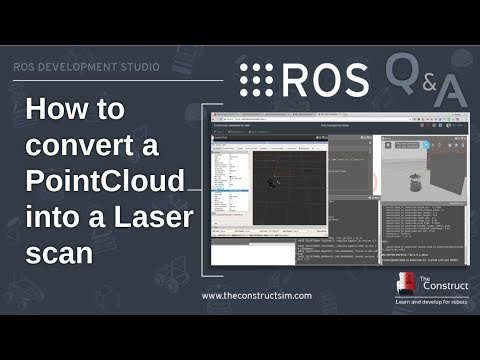

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('IFNikTHN1pk')

What we will use in this solution is just the other people trackers. Here you have the files needed:

<p style="background:#3B8F10;color:white;" id="prg-3-1">**Launch File: start_peopletracker_custom.launch** </p>

In [ ]:
<?xml version="1.0" encoding="UTF-8"?>
<launch>
    <!-- Start navigation -->
    <!-- rostopic info /people_tracker/marker_array -->
    <include file="$(find aibo_project_solutions)/launch/people_tracker_custom.launch" >
        <arg name="load_params_from_file" value="true" />
        
        <arg name="gp_queue_size" value="5" />
        <arg name="vo_queue_size" value="5" />
        <arg name="ubd_queue_size" value="5" />
        <arg name="pt_queue_size" value="10" />
        
        <arg name="camera_namespace" value="/head_camera" />
        <arg name="rgb_image" value="/rgb/image_raw" />
        <arg name="depth_image" value="/depth_registered/image_raw" />
        <arg name="mono_image" value="/depth_registered/image_raw" />
        <arg name="camera_info_rgb" value="/rgb/camera_info" />
        <arg name="camera_info_depth" value="/depth_registered/camera_info" />
        
        <arg name="ground_plane" value="/ground_plane" />
        <arg name="upper_body_detections" value="/upper_body_detector/detections" />
        <arg name="upper_body_bb_centres" value="/upper_body_detector/bounding_box_centres" />
        <arg name="upper_body_markers" value="/upper_body_detector/marker_array" />
        <arg name="upper_body_image" value="/upper_body_detector/image" />
        <arg name="visual_odometry" value="/visual_odometry/motion_matrix" />
        <arg name="people_array" value="/mdl_people_tracker/people_array" />
        <arg name="people_image" value="/mdl_people_tracker/image" />
        <arg name="people_markers" value="/mdl_people_tracker/marker_array" />
        <arg name="people_poses" value="/mdl_people_tracker/pose_array" />
        
        <!--
        <arg name="bayes_people_param_file" value="$(find aibo_project_solutions)/config/detectors.yaml" />
        -->
        
        <arg name="tf_target_frame" value="/base_link" />
    
        <arg name="machine" value="localhost" />
        <arg name="user" value="" />
    </include>
</launch>

<p style="background:#3B8F10;color:white;" id="prg-3-2">**Launch File: people_tracker_custom.launch** </p>

As you can see here we dont use the leg detector.

In [ ]:
<?xml version="1.0" encoding="UTF-8"?>
<launch>
    <!-- Global paramters -->
    <arg name="load_params_from_file" default="true" />
    <arg name="gp_queue_size" default="5" />
    <arg name="vo_queue_size" default="5" />
    <arg name="ubd_queue_size" default="5" />
    <arg name="pt_queue_size" default="10" />
    <arg name="camera_namespace" default="/camera" />
    <arg name="rgb_image" default="/rgb/image_rect_color" />
    <arg name="depth_image" default="/depth/image_rect" />
    <arg name="mono_image" default="/rgb/image_mono" />
    <arg name="camera_info_rgb" default="/rgb/camera_info" />
    <arg name="camera_info_depth" default="/depth/camera_info" />
    <arg name="ground_plane" default="/ground_plane" />
    <arg name="upper_body_detections" default="/upper_body_detector/detections" />
    <arg name="upper_body_bb_centres" default="/upper_body_detector/bounding_box_centres" />
    <arg name="upper_body_markers" default="/upper_body_detector/marker_array" />
    <arg name="upper_body_image" default="/upper_body_detector/image" />
    <arg name="visual_odometry" default="/visual_odometry/motion_matrix" />
    <arg name="people_array" default="/mdl_people_tracker/people_array" />
    <arg name="people_image" default="/mdl_people_tracker/image" />
    <arg name="people_markers" default="/mdl_people_tracker/marker_array" />
    <arg name="people_poses" default="/mdl_people_tracker/pose_array" />
    <arg name="tf_target_frame" default="/base_link" />
    
    <!--
    <arg name="scan" default="/base_scan" />
    -->
    
    <arg name="machine" default="localhost" />
    <arg name="user" default="" />
    
    <arg name="log" default="false" />
    <arg name="manager_topic" default="" />
    
    <arg name="tracker_filter_positions" default="/people_tracker_filter/positions" />
    
    <arg name="tracker_filter_pose" default="/people_tracker_filter/pose" />
    <arg name="tracker_filter_pose_array" default="/people_tracker_filter/pose_array" />
    <arg name="tracker_filter_people" default="/people_tracker_filter/people" />
    <arg name="tracker_filter_marker" default="/people_tracker_filter/marker_array" />
    
    <!--
    <arg name="bayes_people_param_file" default="$(find aibo_project_solutions)/config/detectors.yaml" />
    -->
    <arg name="bayes_people_positions" default="/people_tracker/positions" />
    <arg name="bayes_people_pose" default="/people_tracker/pose" />
    <arg name="bayes_people_pose_array" default="/people_tracker/pose_array" />
    <arg name="bayes_people_people" default="/people_tracker/people" />
    <arg name="bayes_people_marker" default="/people_tracker/marker_array" />

    <machine name="$(arg machine)" address="$(arg machine)" env-loader="$(optenv ROS_ENV_LOADER )" user="$(arg user)" default="true"/>

    <!-- Visual Odometry -->
    <include file="$(find visual_odometry)/launch/visual_odometry.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="queue_size" value="$(arg vo_queue_size)"/>
        <arg name="camera_namespace" value="$(arg camera_namespace)"/>
        <arg name="depth_image" value="$(arg depth_image)"/>
        <arg name="mono_image" value="$(arg mono_image)"/>
        <arg name="camera_info_depth" value="$(arg camera_info_depth)"/>
        <arg name="motion_parameters" value="$(arg visual_odometry)"/>
    </include>

    <!-- Ground Plane -->
    <include file="$(find ground_plane_estimation)/launch/ground_plane_estimated.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="load_params_from_file" value="$(arg load_params_from_file)"/>
        <arg name="queue_size" value="$(arg gp_queue_size)"/>
        <arg name="camera_namespace" value="$(arg camera_namespace)"/>
        <arg name="depth_image" value="$(arg depth_image)"/>
        <arg name="camera_info_rgb" value="$(arg camera_info_rgb)"/>
        <arg name="ground_plane" value="$(arg ground_plane)"/>
    </include>

    <!-- Upper Body Detector -->
    
    <include file="$(find upper_body_detector)/launch/upper_body_detector.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="load_params_from_file" value="$(arg load_params_from_file)"/>
        <arg name="queue_size" value="$(arg ubd_queue_size)"/>
        <arg name="camera_namespace" value="$(arg camera_namespace)"/>
        <arg name="rgb_image" value="$(arg rgb_image)"/>
        <arg name="depth_image" value="$(arg depth_image)"/>
        <arg name="camera_info_depth" value="$(arg camera_info_depth)"/>
        <arg name="upper_body_detections" value="$(arg upper_body_detections)"/>
        <arg name="upper_body_bb_centres" value="$(arg upper_body_bb_centres)"/>
        <arg name="upper_body_markers" value="$(arg upper_body_markers)"/>
        <arg name="upper_body_image" value="$(arg upper_body_image)"/>
        <arg name="ground_plane" value="$(arg ground_plane)"/>
    </include>
    
    

    <!-- Pedestrian Tracking -->
    
    <include file="$(find mdl_people_tracker)/launch/mdl_people_tracker.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="load_params_from_file" value="$(arg load_params_from_file)"/>
        <arg name="queue_size" value="$(arg pt_queue_size)"/>
        <arg name="camera_namespace" value="$(arg camera_namespace)"/>
        <arg name="rgb_image" value="$(arg rgb_image)"/>
        <arg name="camera_info_rgb" value="$(arg camera_info_rgb)"/>
        <arg name="ground_plane" value="$(arg ground_plane)"/>
        <arg name="upper_body_detections" value="$(arg upper_body_detections)"/>
        <arg name="visual_odometry" value="$(arg visual_odometry)"/>
        <arg name="people_array" value="$(arg people_array)"/>
        <arg name="people_image" value="$(arg people_image)"/>
        <arg name="people_markers" value="$(arg people_markers)"/>
        <arg name="people_poses" value="$(arg people_poses)"/>
        <arg name="target_frame" value="$(arg tf_target_frame)"/>
    </include>
    

    <!-- People Tracker -->
    
    <include file="$(find bayes_people_tracker)/launch/people_tracker.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="param_file" value="$(find aibo_project_solutions)/config/detectors.yaml"/>
        <arg name="target_frame" value="$(arg tf_target_frame)"/>
        <arg name="positions" value="$(arg bayes_people_positions)"/>
        <arg name="pose" value="$(arg bayes_people_pose)"/>
        <arg name="pose_array" value="$(arg bayes_people_pose_array)"/>
        <arg name="people" value="$(arg bayes_people_people)"/>
        <arg name="marker" value="$(arg bayes_people_marker)"/>
    </include>
    
    
    <!-- To PoseArray -->
    <!--
    <include file="$(find detector_msg_to_pose_array)/launch/to_pose_array.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
    </include>
    -->
    
   <!-- Logging -->
    <include file="$(find bayes_people_tracker_logging)/launch/logging.launch">
        <arg name="machine" value="$(arg machine)"/>
        <arg name="user" value="$(arg user)"/>
        <arg name="log" value="$(arg log)"/>
        <arg name="manager_topic" value="$(arg manager_topic)"/>
        <arg name="positions" value="$(arg tracker_filter_positions)"/>
    </include>
</launch> 


<p style="background:#3B8F10;color:white;" id="prg-3-3">**Python File: aibo_move_to_person.py** </p>

This python will read from the people tracker launched through **start_peopletracker_custom.launch**, start a searching protocol until it finds a person, then fo to its position until its at a distance of around 3 meters and then it will wiggle its tail.

In [ ]:
#!/usr/bin/env python
import sys
import rospy
import math
import tf
from geometry_msgs.msg import PoseStamped
from geometry_msgs.msg import Twist
from geometry_msgs.msg import Point
from move_aibo import AiboJointMover
import time
import numpy

class AiboPeopleFollower(object):
    
    def __init__(self):
        
        # Minimum distance from subject, closer will give serious probles to see the adult.
        self.min_distance = 3.0

        
        
        self.aibo_mover = AiboJointMover()
        
        self.follower_model_name = "aiboERS7"
        self.aibo_vel = rospy.Publisher(self.follower_model_name+'/cmd_vel', Twist,queue_size=1)
        
        self.check_publishers()
        
        # We set the head to search for adults.
        rospy.loginfo("Moving Head to Adult search position...")
        self.aibo_mover.pub_headTilt_position.publish(-0.7)
        rospy.loginfo("DONE Moving Head to Adult search position...")
        
        self.ctrl_c = False
        rospy.on_shutdown(self.shutdownhook)
       
        self.people_pose = self.check_people_tracking_ready()
        rospy.Subscriber("/people_tracker/pose", PoseStamped, self.people_tracker_pose_callback)
        
            
    def check_people_tracking_ready(self):
        
        people_tracker_data = None
        rospy.logdebug("Waiting for /camera/depth/points to be READY...")
        while people_tracker_data is None and not rospy.is_shutdown():
            
            # Start Searching person
            rospy.loginfo("Searching Person...")
            self.move_aibo(linear=0.0, angular=0.2)
            
            try:
                people_tracker_data = rospy.wait_for_message("/people_tracker/pose", PoseStamped, timeout=2.0)
                rospy.logdebug("Current /people_tracker/pose READY=>")
    
            except:
                rospy.logerr("Current /people_tracker/pose not ready yet, retrying for getting people_tracker_data")
                
        return people_tracker_data.pose
        
    
    def check_pub_headTilt_position_publishers_connection(self):
        """
        Checks that all the publishers are working
        :return:
        """
        rate = rospy.Rate(10)  # 10hz
        while self.aibo_mover.pub_headTilt_position.get_num_connections() == 0 and not rospy.is_shutdown():
            rospy.logdebug("No susbribers to self.aibo_mover.pub_headTilt_position yet so we wait and try again")
            try:
                rate.sleep()
            except rospy.ROSInterruptException:
                # This is to avoid error when world is rested, time when backwards.
                pass
        rospy.logdebug("self.aibo_mover.pub_headTilt_position Publisher Connected")
        
        
    def check_aibo_vel_publishers_connection(self):
        """
        Checks that all the publishers are working
        :return:
        """
        rate = rospy.Rate(10)  # 10hz
        while self.aibo_vel.get_num_connections() == 0 and not rospy.is_shutdown():
            rospy.logdebug("No susbribers to self.aibo_vel yet so we wait and try again")
            try:
                rate.sleep()
            except rospy.ROSInterruptException:
                # This is to avoid error when world is rested, time when backwards.
                pass
        rospy.logdebug("self.aibo_vel Publisher Connected")
        
        
    def check_publishers(self):
        """
        We check that all publishers work
        """
        self.check_pub_headTilt_position_publishers_connection()
        self.check_aibo_vel_publishers_connection()

        rospy.loginfo("All Publishers READY")
                
    def shutdownhook(self):
            print "shutdown time! Stop the robot"
            cmd = Twist()
            cmd.linear.x = 0.0
            cmd.angular.z = 0.0
            self.aibo_vel.publish(cmd)
            self.ctrl_c = True
            
            
    def people_tracker_pose_callback(self,data):
        """
        std_msgs/Header header
          uint32 seq
          time stamp
          string frame_id
        geometry_msgs/Pose pose
          geometry_msgs/Point position
            float64 x
            float64 y
            float64 z
          geometry_msgs/Quaternion orientation
            float64 x
            float64 y
            float64 z
            float64 w
        """
        self.people_pose = data.pose
            
    def start_follow_people_loop(self):
        
        rate = rospy.Rate(10.0)
        
        while not self.ctrl_c:
            
            if self.people_pose:
                trans_0 = self.people_pose.position.x
                trans_1 = self.people_pose.position.y
                
                rospy.loginfo("Translation PeoplePosition = ["+str(trans_0)+","+str(trans_1)+"]")
                
                point_object = Point()
                point_object.x = trans_0
                point_object.y = trans_1
                distance = self.get_vector_magnitude(point_object)
                rospy.loginfo("distance from person = "+str(distance))
                
                if distance > self.min_distance:
                    angular = 4 * math.atan2(trans_1, trans_0)
                    linear = 0.1 * math.sqrt(trans_0 ** 2 + trans_1 ** 2)
                else:
                    angular = 0.0
                    linear = 0.0
                    self.wiggle_tail()
        
                # We now clear the self.people_pose so that only when we detect we move
                self.people_pose = None
    
            else:
                
                # We set the searching mode
                rospy.loginfo("Searching Person...")
                angular = 0.1
                linear = 0.0
            
            
            self.move_aibo(linear, angular)   
    
            rate.sleep()
            
            
    def move_aibo(self, linear, angular):
        
        cmd = Twist()
        cmd.linear.x = linear
        cmd.angular.z = angular
        rospy.loginfo("Move="+str(cmd))
        self.aibo_vel.publish(cmd)
        
        
    def wiggle_tail(self):
        """
        Move the Tail for a Second
        """
        rospy.loginfo("Wiggle Tail!")
        
        tailPan_min = -0.7
        tailPan_max = 0.7
        sleep_time = 0.2
        
        for i in range(3):
            self.aibo_mover.pub_tailPan_position.publish(tailPan_min)
            time.sleep(sleep_time)
            self.aibo_mover.pub_tailPan_position.publish(tailPan_max)
            time.sleep(sleep_time)
            
    
    def get_vector_magnitude(self, point_object):
        """
        Returns the magnitude of the point vector
        """
        numpy_array_vector = numpy.array((point_object.x, point_object.y, point_object.z))
    
        magnitude = numpy.linalg.norm(numpy_array_vector)
    
        return magnitude
            


if __name__ == '__main__':
    rospy.init_node('people_listener_aibo')
    aibofollower = AiboPeopleFollower()
    aibofollower.start_follow_people_loop()
    


So to launch everything you will need to launch the following scripts in different WebShells. We suppose that your project name will be **aibo_project_solutions**:

**To start the people tracker**:

**To start the aibo people tracking move**

**To start the movement of the standing person with the keyboard**